<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_5_FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This file is loosely inspired by the tutorial based on:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

Some of the code in this file is generated by ChatGPT

This file makes use of the MIT-BIH Database

# Dependencies

In [1]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import wfdb

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

import time
import csv
import os
import random

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

# Load the dataset

The MIT-BIH dataset contains 48 half-hour samples of ECG recordings

Each recording corresponds to three raw files:

1. `.hea` describes the recording's sampling rate, channels, etc.
2. `.dat` are a sequence of 12-bit integers encoding the intensity at 360 Hz with a resolution of 1/200 mV
    - there are two channels, but only the first one is consistent
3. `.atr` includes the time stamp and type of each heartbeat

In [2]:
dl_path = "./raw_data/"
# set records to be included here
recordNames = [100, 101, 103, 105, 106, 108, 109]
#recordNames = [102, 100, 102]
# window size for each record
windowSize = 360

batch_size = 32
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")

seed = 22
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
numRec = len(recordNames)

for i in range(numRec):
    recordNames[i] = str(recordNames[i])

print("Number of records: %d" % numRec)

Number of records: 7


# Read the files

The `.dat` file's encoding is automatically converted to double floats in mV when we read it

The `.atr` is read into an object with an array of true labels and an array of time stamps

In [4]:
annos = [] # annotation
records = []

for i in range(numRec):
    annos.append(wfdb.rdann(dl_path + recordNames[i], 'atr'))
    records.append(wfdb.rdrecord(dl_path + recordNames[i]))

print(len(annos[i].sample), len(annos[i].symbol))
    
signals = []
for i in range(numRec):
    # we'll worry about quantization later in the code
    signals.append(records[i].p_signal.astype(np.float32))

2535 2535


## Heartbeat Segmentation

We want each heartbeat in the records to be one data point, those data points should then be shuffled (instead of being grouped by patient)

In [5]:
beats = []
labelChars = [] # label still in strings
for i in range(numRec):
    for pos, label in zip(annos[i].sample, annos[i].symbol):
        winMin = pos - windowSize//2
        winMax = pos + windowSize//2
        if (winMin >=0 and winMax <= len(signals[i])): # this will sacrifice some signals
            segment = signals[i][pos - windowSize//2 : pos + windowSize//2, 0] # channel 0 only
            beats.append(segment)
            labelChars.append(label)

beats = np.stack(beats) # shape: total number of beats * window size
print("Shape of beats:", len(beats), len(beats[0]))

Shape of beats: 15373 360


AAMI suggests five categories out of the multitude of labels from MIT-BIH, we encode them into integers

In [6]:
# N:0 S:1 V:2 F:3 Q:4; 4 is unclassifiable
labelMap = {
    'N':0,'L':0,'R':0,'e':0,'j':0,
    'A':1,'a':1,'J':1,'S':1,
    'V':2,'E':2,
    'F':3,
    'Q':4,'/':4,'?':4,'f':4,'P':4,'t':4
}

labels = [labelMap.get(_x, 4) for _x in labelChars]
print(set(labels))

{0, 1, 2, 3, 4}


## Torch Dataset and Loader

In [7]:
# by ChatGPT
def duplicate_classes(dataset, labels_to_duplicate, factor=2):
    """
    Returns a new dataset where all items whose label is in `labels_to_duplicate`
    are duplicated `factor` times.

    Args:
        dataset (Dataset): The original PyTorch dataset.
        labels_to_duplicate (Iterable): Collection (e.g. list or set) of class labels to duplicate.
        factor (int): How many total copies to include (e.g. 2 means each duplicated item appears twice).

    Returns:
        Dataset: A new dataset containing duplicated samples.
    """
    if factor < 1:
        raise ValueError("factor must be >= 1")

    class DuplicatedDataset(Dataset):
        def __init__(self, base_dataset, labels, factor):
            self.samples = []
            for x, y in base_dataset:
                self.samples.append((x, y))
                # handle cases where y is a tensor
                label_value = y.item() if hasattr(y, "item") else y
                if label_value in labels:
                    # Add duplicates (factor - 1) more times
                    self.samples.extend([(x, y)] * (factor - 1))

        def __len__(self):
            return len(self.samples)

        def __getitem__(self, idx):
            return self.samples[idx]

    return DuplicatedDataset(dataset, set(labels_to_duplicate), factor)

In [8]:
class MB_Dataset(Dataset):
    def __init__(self, beatsT, labelsT, t=torch.float32):
        self.beats = torch.tensor(beatsT, dtype=t)
        self.labels = torch.tensor(labelsT, dtype=torch.long)
    def __len__(self):
        return len(self.beats)
    def __getitem__(self, idx):
        return self.beats[idx], self.labels[idx]
    def shapes(self):
        print(self.beats.shape, self.labels.shape)

datasetO = MB_Dataset(beats, labels)
datasetO.shapes()

dataset = duplicate_classes(datasetO, [1, 2, 3, 4], 10)
len(dataset)

torch.Size([15373, 360]) torch.Size([15373])


23779

In [9]:
from torch.utils.data import random_split

# Example: 80% train, 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

## Data Visualisation

In [10]:
def plot_spikes(spike_data, k=1):
    fig = plt.figure(facecolor="w", figsize=(8, 1))
    ax = fig.add_subplot(111)
    splt.raster(spike_data, ax, c="black")
    plt.title("Input Neuron")
    plt.xlabel("Time step")
    plt.yticks([])
    plt.xlim(0, windowSize*k)
    plt.show()

def plot_beat(data):
    data = data.clone().cpu().detach().numpy()
    plt.plot(data)

    plt.title("beat")
    plt.xlabel("Time step")
    plt.ylabel("Voltage (mV)")
    plt.show()
    
def plot_beat_spikes(beat, spikes):
    beat = beat.clone().cpu().detach().numpy()
    spikes = spikes.clone().cpu().detach().numpy().astype(bool)

    # Create x-axis
    x = np.arange(len(beat))
    z = np.array([0 for i in beats], dtype=int)
    
    # Plot the line for the float values
    plt.plot(x, beat, label="beats", color="blue")

    #print(x[spikes])
    # Plot scatter points where flags are True
    plt.scatter(x[spikes], np.zeros(np.sum(spikes)), 
                color="red", label="spikes", zorder=3, s=4)

    # Make it look nice
    plt.xlabel("time")
    plt.ylabel("mV")
    plt.title("Line and Boolean Scatter Plot")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    #plt.ylim(-1, 1)
    plt.show()

-----
showcasing sample 16868
truth class: tensor(2)


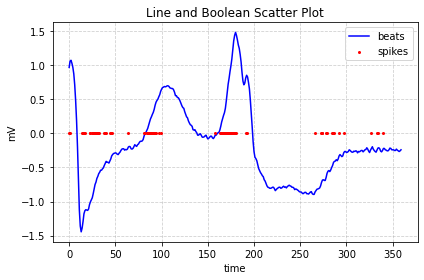

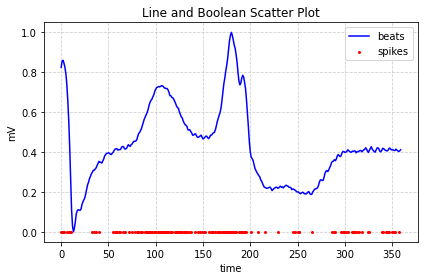

In [24]:
for i in range(1):
    print("-----")
    
    ri = random.randint(0, len(dataset))
    
    print("showcasing sample", ri)
    print("truth class:", dataset[ri][1])

    beat = dataset[ri][0]


    spikeData = spikegen.delta(beat, threshold=0.03)
    plot_beat_spikes(beat,spikeData)
    
    # to create a spike train, we repeat every sample multiple times
    k = 1
    if (k > 1):
        beat = beat.unsqueeze(-1).repeat(1, k).view(-1)
    # normalise
    beat = (beat - beat.min()) / (beat.max() - beat.min())
    spikeData = spikegen.rate(beat, time_var_input=True)
    plot_beat_spikes(beat,spikeData)

    
                

# Define the Network(s)

## SNN_Baseline

In [12]:
# accepts a tensor of num_steps×batchx1
class SNN_Baseline(nn.Module):
    def __init__(self, beta=0.95, qbits = 8, fbits = 6):
        super().__init__()
        self.name = "SNN_Baseline"
        
        # Temporal Dynamics
        self.beta = beta

        # ensure all internal operations are done on fixed point
        self.quant = False
        # the total number of bits we can use
        self.qbits = qbits
        self.fbits = fbits # the number of bits representing fractions
        
        # Network Architecture
        num_inputs = 2
        num_outputs = 5 # five classes

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, 64, bias=False)
        self.lif1 = snn.Leaky(beta=self.beta)
        self.fc2 = nn.Linear(64, num_outputs, bias=False)
        self.lif2 = snn.Leaky(beta=self.beta)

    # quantize any tensor according to the model's rules
    def quantize(self, x):
        if (not self.quant):
            return x
        # e.g. quantize 1.1 with 4 bits incl. 2 fraction bits, 2's complement:
        # 1. find the upper and lower bounds 0b(01.11)=1.75; 0b(10.00)=-2
        # 2. clamp it if necessary
        # 3. scale it by 2^3=8 => 1.1*8=8.8
        # 4. round it to a whole number: round(8.8)=9=0b1001
        # 5. scale back 9/8=1.125=0b(1.001) which is the closest we can do
        # boundary check        
        scale = 1 << self.fbits
        
        ub = ((1 << (self.qbits-1))-1) / scale
        lb = ((1 << (self.qbits-1))*-1)/ scale
        x = torch.clamp(x, lb, ub)
        
        x = x *scale 
        x = torch.round(x)
        
        x = x / scale

        return x

    # toggle quantized mode, irreversible for now
    def quant_mode(self):
        if (not self.quant):
            self.quant = True
            self.fc1.weight.data = self.quantize(self.fc1.weight.data)
            self.fc2.weight.data = self.quantize(self.fc2.weight.data)

    # can report the hidden value for logging
    def forward(self, x, num_steps, hidden=False):
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        mem1_rec = []
        
        # Record the final layer
        spkx_rec = []
        memx_rec = []

        # Feed in the spikes of the entire batch at a given time step in parallel
        for step in range(num_steps):
            # the weights are already quant'd, no need to quant spikes
            cur1 = self.fc1(x[step])
            # the resulting multiple is still quant'd
            cur1 = torch.clamp(cur1, 0, None) # room for optimisation for quant

            # potential quant bug: depending on how the currents are summed up they
            # will have the same precision, but can exceed the upper bound
            spk1, mem1 = self.lif1(cur1, mem1)
            # consistently quant mem1 after use
            mem1 = self.quantize(mem1)
            cur2 = self.fc2(spk1)
            cur2 = torch.clamp(cur2, 0, None)
            
            spk2, mem2 = self.lif2(cur2, mem2)
            # consistently quant mem2 after use
            mem2 = self.quantize(mem2)
            
            spkx_rec.append(spk2)
            memx_rec.append(mem2)

            
            if (hidden):
                mem1_rec.append(mem1)
        
        if (hidden):
            mem1_rec = torch.stack(mem1_rec, dim=0)
        else:
            mem1_rec = None

        return (torch.stack(spkx_rec, dim=0),
                torch.stack(memx_rec, dim=0),
                mem1_rec)

## SNN_Big

In [13]:
# accepts a tensor of num_steps×batchx1
class SNN_Big(nn.Module):
    def __init__(self, beta=0.95, qbits = 8, fbits = 6):
        super().__init__()
        self.name = "SNN_Big"
        
        # Temporal Dynamics
        self.beta = beta

        # ensure all internal operations are done on fixed point
        self.quant = False
        # the total number of bits we can use
        self.qbits = qbits
        self.fbits = fbits # the number of bits representing fractions
        
        # Network Architecture
        num_inputs = 2
        num_outputs = 5 # five classes

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, 64, bias=False)
        self.lif1 = snn.Leaky(beta=self.beta)
        self.fc2 = nn.Linear(64, 128, bias=False)
        self.lif2 = snn.Leaky(beta=self.beta)
        self.fc3 = nn.Linear(128, 64, bias=False)
        self.lif3 = snn.Leaky(beta=self.beta)
        self.fc4 = nn.Linear(64, num_outputs, bias=False)
        self.lif4 = snn.Leaky(beta=self.beta)

    # quantize any tensor according to the model's rules
    def quantize(self, x):
        if (not self.quant):
            return x
        # e.g. quantize 1.1 with 4 bits incl. 2 fraction bits, 2's complement:
        # 1. find the upper and lower bounds 0b(01.11)=1.75; 0b(10.00)=-2
        # 2. clamp it if necessary
        # 3. scale it by 2^3=8 => 1.1*8=8.8
        # 4. round it to a whole number: round(8.8)=9=0b1001
        # 5. scale back 9/8=1.125=0b(1.001) which is the closest we can do
        # boundary check        
        scale = 1 << self.fbits
        
        ub = ((1 << (self.qbits-1))-1) / scale
        lb = ((1 << (self.qbits-1))*-1)/ scale
        x = torch.clamp(x, lb, ub)
        
        x = x *scale 
        x = torch.round(x)
        
        x = x / scale

        return x

    # toggle quantized mode, irreversible for now
    def quant_mode(self):
        if (not self.quant):
            self.quant = True
            self.fc1.weight.data = self.quantize(self.fc1.weight.data)
            self.fc2.weight.data = self.quantize(self.fc2.weight.data)
            self.fc3.weight.data = self.quantize(self.fc3.weight.data)
            self.fc4.weight.data = self.quantize(self.fc4.weight.data)

    # can report the hidden value for logging
    def forward(self, x, num_steps, hidden=False):
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()

        mem1_rec = []
        
        # Record the final layer
        spkx_rec = []
        memx_rec = []

        # Feed in the spikes of the entire batch at a given time step in parallel
        for step in range(num_steps):
            # the weights are already quant'd, no need to quant spikes
            cur1 = self.fc1(x[step])
            # the resulting multiple is still quant'd
            #cur1 = torch.clamp(cur1, 0, None) # room for optimisation for quant
            # potential quant bug: depending on how the currents are summed up they
            # will have the same precision, but can exceed the upper bound
            spk1, mem1 = self.lif1(cur1, mem1)
            # consistently quant mem1 after use
            mem1 = self.quantize(mem1)
            
            cur2 = self.fc2(spk1)
            #cur2 = torch.clamp(cur2, 0, None)
            spk2, mem2 = self.lif2(cur2, mem2)
            # consistently quant mem2 after use
            mem2 = self.quantize(mem2)
            
            cur3 = self.fc3(spk2)
            #cur3 = torch.clamp(cur3, 0, None)
            spk3, mem3 = self.lif3(cur3, mem3)
            # consistently quant mem3 after use
            mem3 = self.quantize(mem3)

            cur4 = self.fc4(spk3)
            #cur4 = torch.clamp(cur4, 0, None)
            spk4, mem4 = self.lif4(cur4, mem4)
            # consistently quant mem4 after use
            mem4 = self.quantize(mem4)
            
            spkx_rec.append(spk4)
            memx_rec.append(mem4)

            
            if (hidden):
                mem1_rec.append(mem1)
        
        if (hidden):
            mem1_rec = torch.stack(mem1_rec, dim=0)
        else:
            mem1_rec = None

        return (torch.stack(spkx_rec, dim=0),
                torch.stack(memx_rec, dim=0),
                mem1_rec)

# Quantization Demo


In [14]:
# A quantized number should be whole when shifted

def quant_sanity(x, fbits):
    # assisted by ChatGPT
    x = x * (2**fbits)
    return torch.all(x == torch.round(x)).item()

# temporary net for demo
tnet = SNN_Baseline(0, 8, 6)

print((tnet.fc1.weight.data * (2 ** tnet.fbits))[:2, :2])

tnet.quant_mode()
print((tnet.fc1.weight.data * (2 ** tnet.fbits))[:2, :2])

x = torch.tensor([1, 0.11, -0.34, 0.004, -1])
print(quant_sanity(x, tnet.fbits))
x = tnet.quantize(x)

print(x)

print(quant_sanity(x, tnet.fbits))

tnet=None

tensor([[ 4.2243, 38.9836],
        [11.2654, 15.1951]])
tensor([[ 4., 39.],
        [11., 15.]])
False
tensor([ 1.0000,  0.1094, -0.3438,  0.0000, -1.0000])
True


# Evaluation Functions

In [15]:
# by chatgpt

def f1_score(y_true: torch.Tensor, y_pred: torch.Tensor, average: str = 'macro') -> float:
    """
    Compute the F1 score between true and predicted labels.
    
    Args:
        y_true (torch.Tensor): Ground truth labels, shape (N,)
        y_pred (torch.Tensor): Predicted labels, shape (N,)
        average (str): 'macro', 'micro', or 'weighted'
    
    Returns:
        float: The F1 score.
    """
    # Ensure tensors are 1D and same shape
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)
    assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"

    classes = torch.unique(y_true)
    f1_scores = []

    for cls in classes:
        tp = torch.sum((y_pred == cls) & (y_true == cls)).item()
        fp = torch.sum((y_pred == cls) & (y_true != cls)).item()
        fn = torch.sum((y_pred != cls) & (y_true == cls)).item()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
        f1_scores.append(f1)

    f1_scores = torch.tensor(f1_scores)

    if average == 'macro':
        return f1_scores.mean().item()
    elif average == 'micro':
        # Micro-average over all classes
        tp = torch.sum(y_true == y_pred).item()
        total = len(y_true)
        return tp / total  # This is accuracy, equivalent to micro-F1 when labels are balanced
    elif average == 'weighted':
        supports = torch.tensor([(y_true == cls).sum().item() for cls in classes], dtype=torch.float)
        return (f1_scores * supports / supports.sum()).sum().item()
    else:
        raise ValueError("average must be one of 'macro', 'micro', or 'weighted'")

In [16]:
def plot_loss(loss_hist):
    fig = plt.figure(facecolor="w", figsize=(10, 5))
    plt.plot(loss_hist)
    plt.title("Loss Curves")
    plt.legend(["Train Loss", "Test Loss"])
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()

def evaluate(net, windowSize, spikeTrainSize, deltaThr, targetRegion, quant=False):
    total = 0
    correct = 0

    deltaEn = deltaThr > 0

    num_steps = windowSize*spikeTrainSize
    
    # drop_last switched to False to keep all samples
    testLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

    totalLabels = []
    totalPredictions = []
    
    with torch.no_grad():
        net.eval()
        if (quant):
            net.quant_mode()
        for data, targets in testLoader:
            data = data.to(device)
            targets = targets.to(device)
              
            if (not deltaEn): # we need to normalise for rate encoding
                dmin = data.min(dim=1, keepdim=True).values
                dmax = data.max(dim=1, keepdim=True).values
                data = (data-dmin) / (dmax-dmin)
            # to create a spike train, we repeat every sample multiple times
            if (spikeTrainSize > 1):
                dataS = data.unsqueeze(-1)
                dataS = dataS.repeat(1, 1, spikeTrainSize)
                data = dataS.view(-1, num_steps)
                
            # data is now batchx(num_steps), but we need it in (num_steps)xbatchx1 
            data = (data.unsqueeze(0)).permute(2, 1, 0)
            if (deltaEn):
                spikeDataP = spikegen.delta(data, threshold=deltaThr)
                spikeDataN = spikegen.delta(-data, threshold=deltaThr)
                spikeData = torch.cat((spikeDataP, spikeDataN), dim=2)
            else:
                spikeData = spikegen.rate(data, time_var_input=True)
            # spikeData should be in (num_steps)xbatchxinputs


            # forward pass
            test_spk, mem_rec, mem1_rec = net(spikeData, num_steps, True)

            # sample plots
            if (random.randint(0, 10000) < 800) and False:
                b = random.randint(0, len(data[0])-1)
                spikes = spikeData.permute(2, 1, 0)[0][b]
                plot_beat_spikes(data.permute(2, 1, 0)[0][b], spikes)
                plot_beat_spikes(mem1_rec.permute(2, 1, 0)[47][b], spikes)
                plot_beat_spikes(mem_rec.permute(2, 1, 0)[0][b], test_spk.permute(2, 1, 0)[0][b])
                plot_beat_spikes(mem_rec.permute(2, 1, 0)[3][b], test_spk.permute(2, 1, 0)[3][b])
            
            test_spk = test_spk[targetRegion[0]:targetRegion[1]]
        
            #print(test_spk.sum(dim=0))
            # calculate total accuracy
            _, predicted = test_spk.sum(dim=0).max(1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
            totalLabels.append(targets)
            totalPredictions.append(predicted)
    
    print(f"Total correctly classified: {correct}/{total}")
    print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

    # Confusion Matrix
    truth = torch.cat(totalLabels)
    pred = torch.cat(totalPredictions)

    confusion_mat = confusion_matrix(truth.cpu(), pred.cpu())

    print("F1:", f1_score(truth.cpu(), pred.cpu()))

    # Display the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat,
                annot=True,
                fmt="d",
                cmap="Blues",
                xticklabels=[f"Class {i}" for i in range(5)],
                yticklabels=[f"Class {i}" for i in range(5)])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    return correct / total



# The Training Function

In [17]:
def train_net(net, windowSize, spikeTrainSize, deltaThr, targetRegion, num_epochs):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.999))

    # each sample in the window can generate multiple spikes for rate encoding
    num_steps = windowSize*spikeTrainSize

    deltaEn = (deltaThr > 0) # disable delta if the threshold is negative
    
    loss_hist = []
    counter = 0
    
    # Outer training loop
    for epoch in range(num_epochs):
        iter_counter = 0
        train_batch = iter(train_loader)
    
        # Minibatch training loop
        for data, targets in train_batch:
            # data is batchxwindowSize
            data = data.to(device)
            targets = targets.to(device)

            if (not deltaEn): # we need to normalise for rate encoding
                dmin = data.min(dim=1, keepdim=True).values
                dmax = data.max(dim=1, keepdim=True).values
                data = (data-dmin) / (dmax-dmin)

            # to create a spike train, we repeat every sample multiple times
            if (spikeTrainSize > 1):
                dataS = data.unsqueeze(-1)
                dataS = dataS.repeat(1, 1, spikeTrainSize)
                data = dataS.view(-1, num_steps)

            # data is now batchx(num_steps), but we need it in (num_steps)xbatchx1 
            data = (data.unsqueeze(0)).permute(2, 1, 0)
            
            if (deltaEn):
                spikeDataP = spikegen.delta(data, threshold=deltaThr)
                spikeDataN = spikegen.delta(-data, threshold=deltaThr)
                spikeData = torch.cat((spikeDataP, spikeDataN), dim=2)
            else:
                spikeData = spikegen.rate(data, time_var_input=True)
            # spikeData should be in (num_steps)xbatchxinputs


            # forward pass
            net.train()
            spk_rec, mem_rec, mem1_rec = net(spikeData, num_steps, False)

            # sample plots
            if (random.randint(0, 10000) < 200) and False:
                b = random.randint(0, len(data[0])-1)
                spikes = spikeData.permute(2, 1, 0)[0][b]
                plot_beat_spikes(data.permute(2, 1, 0)[0][b], spikes)
                plot_beat_spikes(mem1_rec.permute(2, 1, 0)[47][b], spikes)
                plot_beat_spikes(mem_rec.permute(2, 1, 0)[0][b], spk_rec.permute(2, 1, 0)[0][b])
                plot_beat_spikes(mem_rec.permute(2, 1, 0)[3][b], spk_rec.permute(2, 1, 0)[3][b])


            # initialize the loss & sum over time
            loss_val = torch.zeros((1), dtype=torch.float32, device=device)
            for step in range(targetRegion[0], targetRegion[1]):
                loss_val += loss(mem_rec[step], targets)
            loss_val = loss(spk_rec.sum(dim=0), targets)
    
            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
    
            # Store loss history for future plotting
            loss_hist.append(loss_val.item())

            counter += batch_size

            print("\rProgress: loss %3.2f %8d / %8d  " % (loss_val.item(), counter, len(train_dataset)*num_epochs), end='', flush=True)
    return loss_hist
            

# Training Loop

In [29]:
# List of tuples of format (model, beta, qbits, fbits, spikeTrain, deltaThr, num_epochs)
hyperList = [
    #(SNN_Baseline, 0.995, 8, 5, 1, 0.03, 2),
    #(SNN_Baseline, 0.995, 8, 5, 1, 0.03, 1),
    #(SNN_Baseline, 1, 8, 5, 1, 0.03, 2),
    #(SNN_Baseline, 1, 8, 5, 1, 0.03, 1),
    #(SNN_Big, 1, 16, 12, 1, 0.01, 10),
    (SNN_Big, 0.995, 16, 12, 1, 0.03, 2),
]

In [30]:
# cache
csv_file = 'hyper_result_cache.csv'
results = {}
if os.path.exists(csv_file):
    with open(csv_file, mode='r', newline='') as f:
        reader = csv.reader(f)
        for row in reader:
            key_str, result = row
            results[key_str] = result

Training for (<class '__main__.SNN_Big'>, 0.995, 16, 12, 1, 0.03, 2)
Progress: loss 1.24    38016 /    38046  
Finished, time elapsed 655.89 s


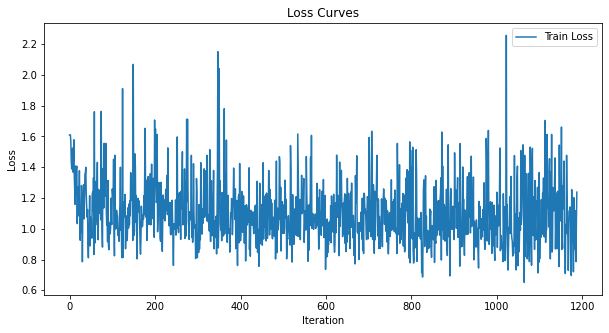

Total correctly classified: 3424/4756
Test Set Accuracy: 71.99%
F1: 0.28778547048568726


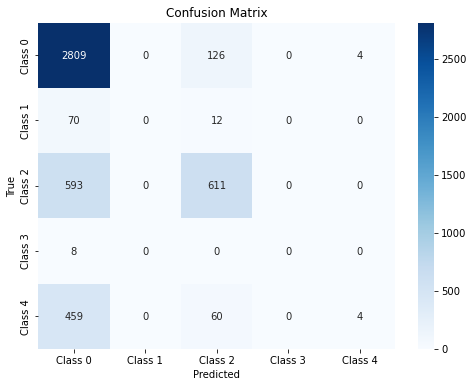

Total correctly classified: 3226/4756
Test Set Accuracy: 67.83%
F1: 0.2858792841434479


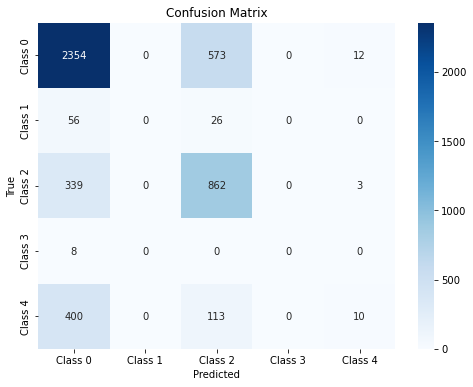

-----



In [31]:
net = None # cache a global net is useful
for hyper in hyperList:

    shyper = str(hyper) + str(recordNames)
    if (shyper in results) and False:
        print("Cached hyper", hyper)
        print(f"Test Set Accuracy: {100 * float(results[shyper]):.2f}%")
        continue
        
    print("Training for", hyper)
    startTime = time.time()
    
    net = hyper[0](hyper[1], hyper[2], hyper[3])
    loss_hist = train_net(net = net.to(device),
                          windowSize = windowSize,
                          spikeTrainSize = hyper[4],
                          deltaThr = hyper[5],
                          targetRegion = (0, 360),
                          num_epochs = hyper[6])

    print("\nFinished, time elapsed %.2f s" % (time.time()-startTime))
    plot_loss(loss_hist)
    accu = evaluate(net, windowSize, hyper[4], hyper[5], (0, 360))
    accu = evaluate(net, windowSize, hyper[4], hyper[5], (0, 360), True)
    print("-----\n")

    with open(csv_file, mode='a', newline='') as f:
        writer = csv.writer(f)
        results[shyper] = accu
        writer.writerow([shyper, accu])